In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tomo2mesh.misc import viewer
from tomo2mesh.structures.datafile import DataFile
from tomo2mesh.projects.eaton.params import pixel_size_1X as pixel_size
from tomo2mesh.misc.voxel_processing import TimerGPU, edge_map, modified_autocontrast, get_values_cyl_mask, cylindrical_mask, TimerCPU
from tomo2mesh.projects.eaton.rw_utils_ae import read_raw_data_1X, save_path
from tomo2mesh.projects.eaton.recon import recon_binned, recon_all
import tifffile as tf

from skimage.filters import threshold_otsu


In [2]:
pixel_res = pixel_size # micrometer per pixel
def transform_ax2(img):
    img = np.fliplr(img)
    img = np.rot90(img)
    return img
shading = 'gray'

In [3]:
z_crop = (1536//2,1536)
b = 4
sample_tag = "1"
scan_tag = ["124","125","126","127","128"]
rdf = pd.read_csv(save_path)


In [4]:
info = rdf[(rdf["sample_num"] == str(sample_tag))]
y_pos_list = list(info['y_pos'])
y_pos_list = np.asarray(y_pos_list)*1.0e3/(pixel_size*b)
y_pos_list = (y_pos_list - y_pos_list[0]).astype(np.uint64)
z_max = np.uint32(np.diff(y_pos_list))


In [5]:
V_stack = []
for i in range(len(scan_tag)):
    projs, theta, center, dark, flat = read_raw_data_1X(sample_tag, scan_tag[i])
    
    V = recon_binned(projs, theta, center, dark, flat, b, pixel_size).get()
    # h = modified_autocontrast(V)
    # V = np.clip(V, *h)
    # cylindrical_mask(V, 1.0, mask_val = V.min())
    if i==0:
        z_crop = (1536//2,1536)
    elif i==len(scan_tag)-1:
        z_crop = (0,1536//2)
    else:
        z_crop = (0,1536)
        
    if i!=len(scan_tag)-1:
        V = V[slice(z_crop[0]//b, z_max[i]),...]
    else:
        V = V[slice(z_crop[0]//b, z_crop[1]//b),...]
    V_stack.append(V)
    
    dfile = DataFile(f"/data01/Eaton_Polymer_AM/reconstructed/sample{sample_tag}_scan{scan_tag[i]}_b{b}", tiff = True, d_shape = V.shape, d_type = V.dtype)
    dfile.create_new(overwrite = True)
    dfile.write_full(V)
    
V_stack_adj = np.concatenate(V_stack, axis=0)


/data01/Tomo2Mesh/tomo2mesh/projects/eaton/recon.py:177: FutureWarning: cupy.fft.cache.clear_plan_cache is experimental. The interface can change in the future.
  cp.fft.config.clear_plan_cache()


Removed old contents in tiff folder sample1_scan124_b4


/data01/Tomo2Mesh/tomo2mesh/projects/eaton/recon.py:177: FutureWarning: cupy.fft.cache.clear_plan_cache is experimental. The interface can change in the future.
  cp.fft.config.clear_plan_cache()


Removed old contents in tiff folder sample1_scan125_b4


/data01/Tomo2Mesh/tomo2mesh/projects/eaton/recon.py:177: FutureWarning: cupy.fft.cache.clear_plan_cache is experimental. The interface can change in the future.
  cp.fft.config.clear_plan_cache()


Removed old contents in tiff folder sample1_scan126_b4


/data01/Tomo2Mesh/tomo2mesh/projects/eaton/recon.py:177: FutureWarning: cupy.fft.cache.clear_plan_cache is experimental. The interface can change in the future.
  cp.fft.config.clear_plan_cache()


Removed old contents in tiff folder sample1_scan127_b4


/data01/Tomo2Mesh/tomo2mesh/projects/eaton/recon.py:177: FutureWarning: cupy.fft.cache.clear_plan_cache is experimental. The interface can change in the future.
  cp.fft.config.clear_plan_cache()


Removed old contents in tiff folder sample1_scan128_b4


In [6]:
sample_tag = "1"
scan_tag = "124"
V = DataFile(f"/data01/Eaton_Polymer_AM/reconstructed/sample{sample_tag}_scan{scan_tag}_b{b}", tiff = True).read_full()



##################################################
Found existing tiff folder: sample1_scan124_b4
Dataset shape: (159, 612, 612)


In [16]:
cylindrical_mask(V_stack_adj, 1.0, mask_val = V_stack_adj.min())
imm = viewer.get_orthoplanes(vol = V_stack_adj)


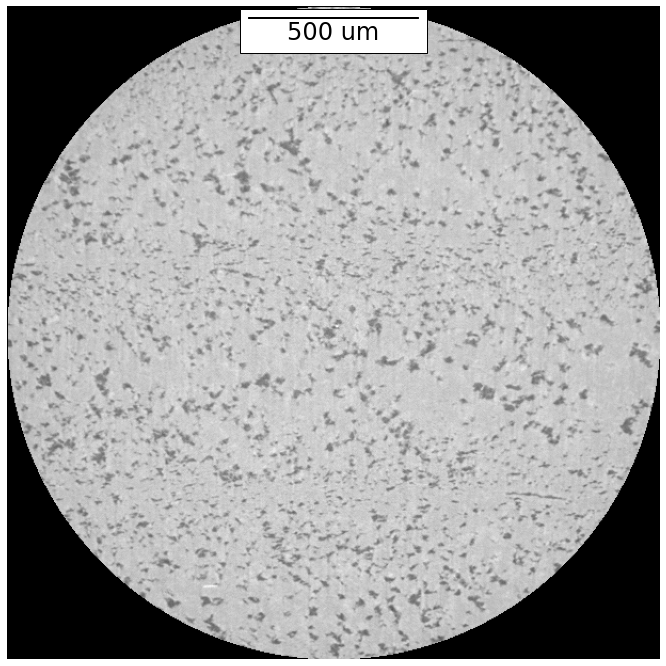

In [17]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
#viewer.edge_plot(imx[0], imp[0], ax, color =[0,0,255])
ax.imshow(imm[0], cmap = shading, alpha = 1) #0.25
viewer.add_scalebar(ax, 500, pixel_size, loc = 'upper center', fontsize = 24)
ax.axis('off')
tf.imsave("/home/yash/eaton_plots2/ortho_slices_horiz.tiff",imm[0])


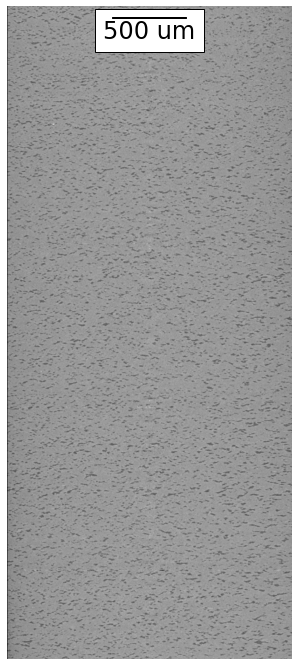

In [18]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
#viewer.edge_plot(imx[1], imp[1], ax, color =[0,0,255])
ax.imshow(imm[1], cmap = shading, alpha = 1) #0.25
viewer.add_scalebar(ax, 500, pixel_size, loc = 'upper center', fontsize = 24)
ax.axis('off')
tf.imsave("/home/yash/eaton_plots2/ortho_slices_vert1.tiff",imm[1])


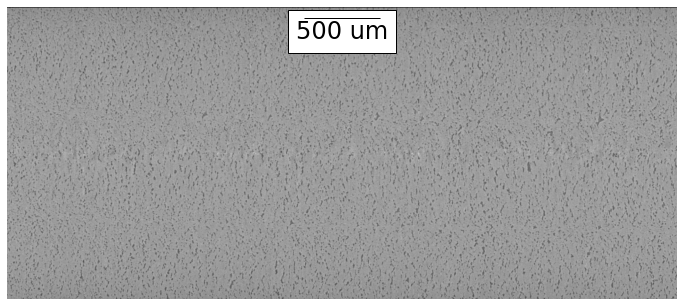

In [20]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
#viewer.edge_plot(transform_ax2(imx[2]), transform_ax2(imp[2]), ax, color =[0,0,255])
ax.imshow(transform_ax2(imm[2]), cmap = shading, alpha = 1) #0.25
viewer.add_scalebar(ax, 500, pixel_size, loc = 'upper center', fontsize = 24)
ax.axis('off')
tf.imsave("/home/yash/eaton_plots2/ortho_slices_vert1.tiff",imm[2])
